# SMS Spam Classifier

## Attribute Information:

The collection is composed by just one text file, where each line has the correct class followed by the raw message. We offer some examples bellow:

<b>ham</b> What you doing?how are you? <br>
<b>ham</b> Ok lar... Joking wif u oni...<br>
<b>ham</b> dun say so early hor... U c already then say...<br>
<b>ham</b> MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*<br>
<b>ham</b> Siva is in hostel aha:-.<br>
<b>ham</b> Cos i was out shopping wif darren jus now n i called him 2 ask wat present he wan lor. Then he started guessing who i was wif n he finally guessed darren lor.<br>

<b>spam</b> FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop<br>
<b>spam</b> Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B<br>
<b>spam</b> URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU<br>

Note: the messages are not chronologically sorted.

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import string
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud

from scipy.stats import shapiro, mannwhitneyu

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from jcopml.tuning.space import Real, Integer

import warnings
warnings.filterwarnings("ignore")

In [73]:
spam = pd.read_csv('spam.csv', encoding='latin-1')

In [74]:
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [75]:
spam = spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
spam.shape

(5572, 2)

In [76]:
spam.drop_duplicates(inplace = True)
spam.shape

(5169, 2)

In [77]:
spam.rename(columns = {'v1' : 'label', 'v2' : 'text'}, inplace = True)

In [78]:
spam.describe()

,label,text
count,5169,5169
unique,2,5169
top,ham,We'll join the &lt;#&gt; bus
freq,4516,1


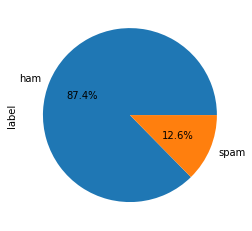

In [79]:
spam['label'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')

In [80]:
spam.isna().sum()

label    0
text     0
dtype: int64

# Exploratory Data Analysis 

## Feature Engineering

In [81]:
spam['length'] = spam['text'].apply(len)

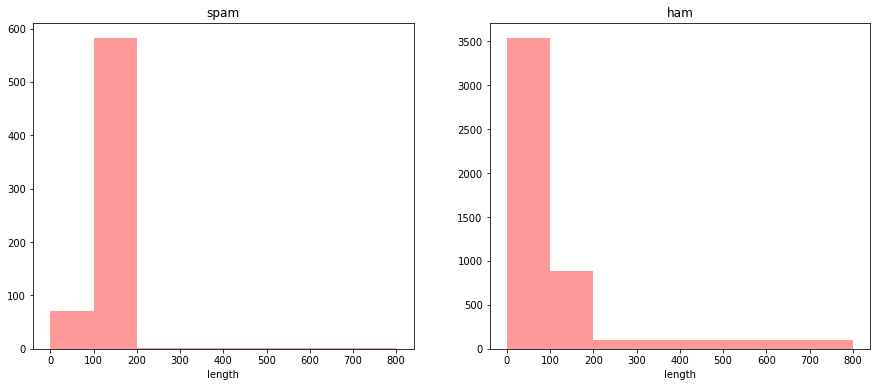

In [82]:
fig, axes = plt.subplots(1, 2, figsize = (15,6))

for cat, ax in zip(['spam', 'ham'], axes.flatten()):
    ax.set_title(cat)
    sns.distplot(spam[spam['label'] == cat]['length'], kde = False, color = 'red', ax = ax, bins = [0, 100, 200, 800])

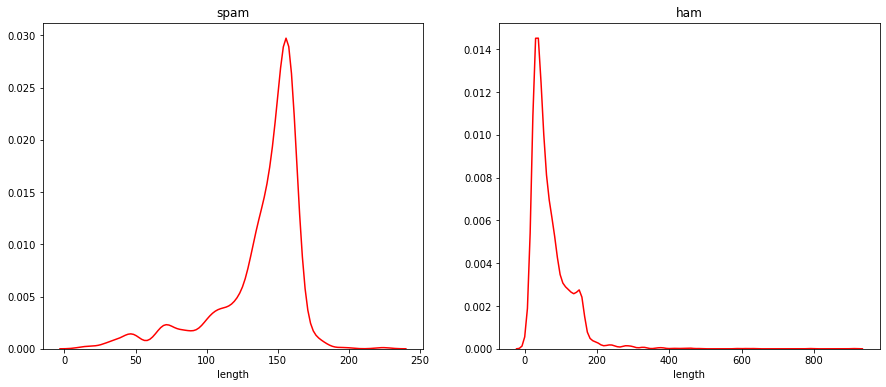

In [83]:
fig, axes = plt.subplots(1, 2, figsize = (15,6))

for cat, ax in zip(['spam', 'ham'], axes.flatten()):
    ax.set_title(cat)
    sns.distplot(spam[spam['label'] == cat]['length'], hist = False, color = 'red', ax = ax)

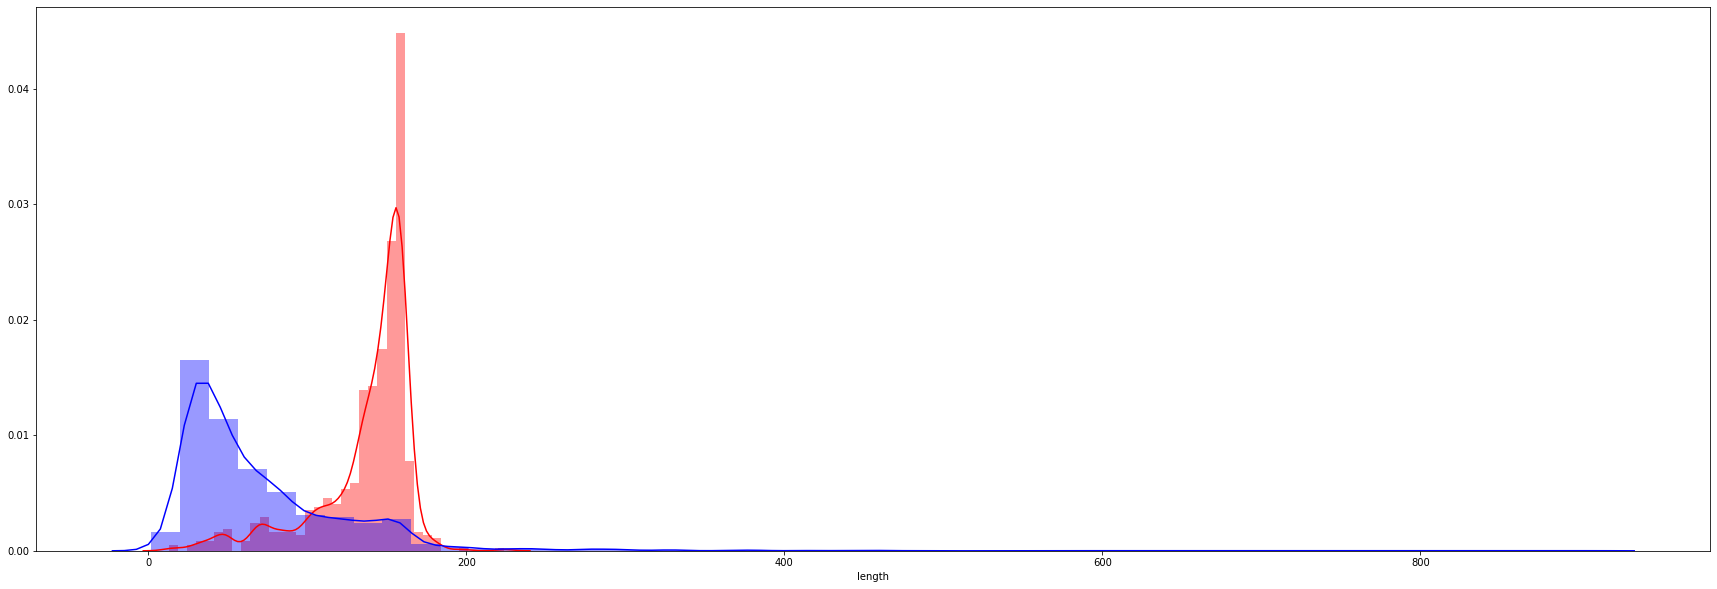

In [84]:
plt.figure(figsize = (30,10))
sns.distplot(spam[spam['label'] == 'spam']['length'], color = 'red')
sns.distplot(spam[spam['label'] == 'ham']['length'], color = 'blue')

> Pada visualisasi di atas, terlihat bahwa karakter-karakter pada pesan <i>spam</i> umumnya lebih panjang dan banyak daripada pesan <i>ham</i>. <i>Insight</i> di atas masuk akal, mengingat kebanyakan pesan-pesan <i>spam</i> lebih mengarah seperti ke pesan-pesan menang undian atau pesan-pesan yang seolah-olah penting. Sedangkan pesan-pesan <i>ham</i> adanya pesan-pesan cepat atau pesan singkat. 

In [85]:
spam['words'] = spam['text'].apply(lambda x : len(x.split()))

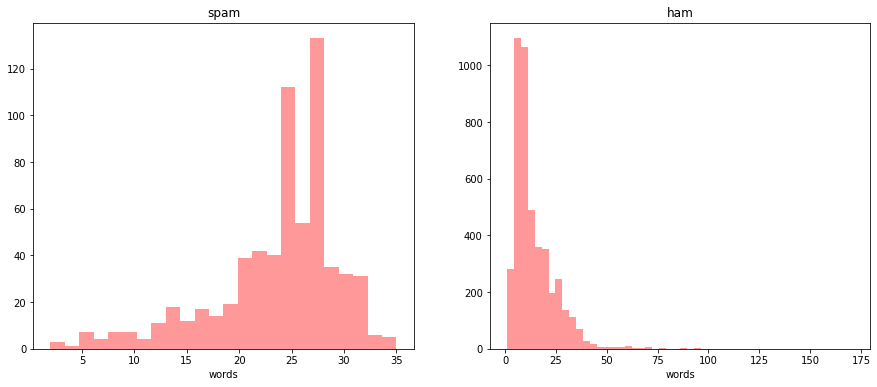

In [86]:
fig, axes = plt.subplots(1, 2, figsize = (15,6))

for cat, ax in zip(['spam', 'ham'], axes.flatten()):
    ax.set_title(cat)
    sns.distplot(spam[spam['label'] == cat]['words'], kde = False, color = 'red', ax = ax)

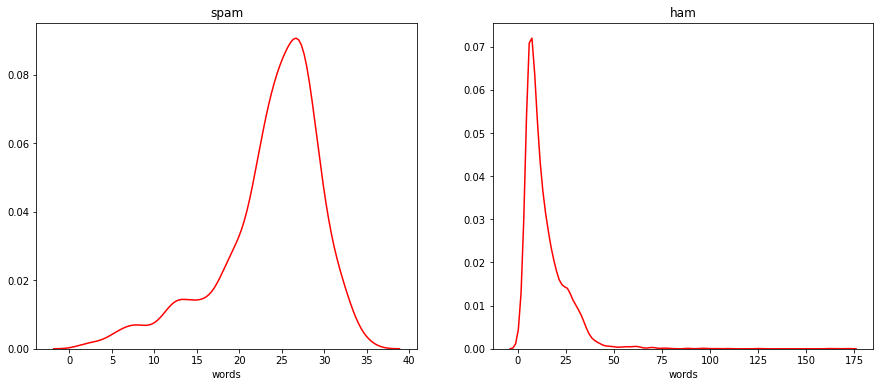

In [87]:
fig, axes = plt.subplots(1, 2, figsize = (15,6))

for cat, ax in zip(['spam', 'ham'], axes.flatten()):
    ax.set_title(cat)
    sns.distplot(spam[spam['label'] == cat]['words'], hist = False, color = 'red', ax = ax)

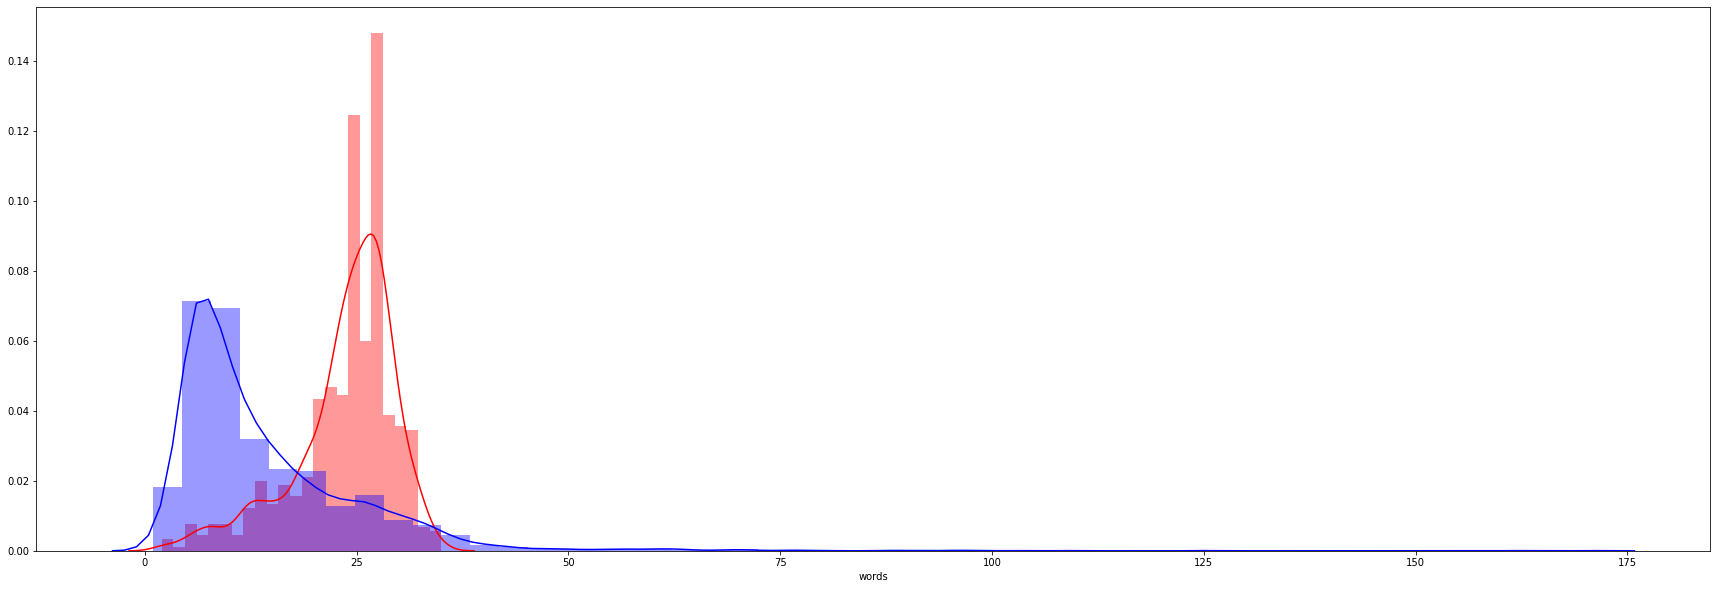

In [88]:
plt.figure(figsize = (30,10))
sns.distplot(spam[spam['label'] == 'spam']['words'], color = 'red')
sns.distplot(spam[spam['label'] == 'ham']['words'], color = 'blue')

> Begitu juga dengan banyaknya kata, banyaknya kata pada <i>spam</i> umumnya lebih banyak dari <i>ham</i>.

## Statistical Analysis

### Normality Test

In [89]:
shap = []

for i in ['length','words']:
    if shapiro(spam[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = ['length','words'])

,Hypothesis
length,Reject Null Hypothesis
words,Reject Null Hypothesis


### Significance Test

In [90]:
mann = []

for i in ['length', 'words']:
    if mannwhitneyu(spam[spam['label'] == 'ham'][i], spam[spam['label'] == 'spam'][i])[1] < 0.05:
        mann.append('Reject Null Hypothesis')
    else:
        mann.append('Fail To Reject Null Hypothesis')

pd.DataFrame({'Hypothesis' : mann}, index = ['length','words'])

,Hypothesis
length,Reject Null Hypothesis
words,Reject Null Hypothesis


### Bootstrap distribution

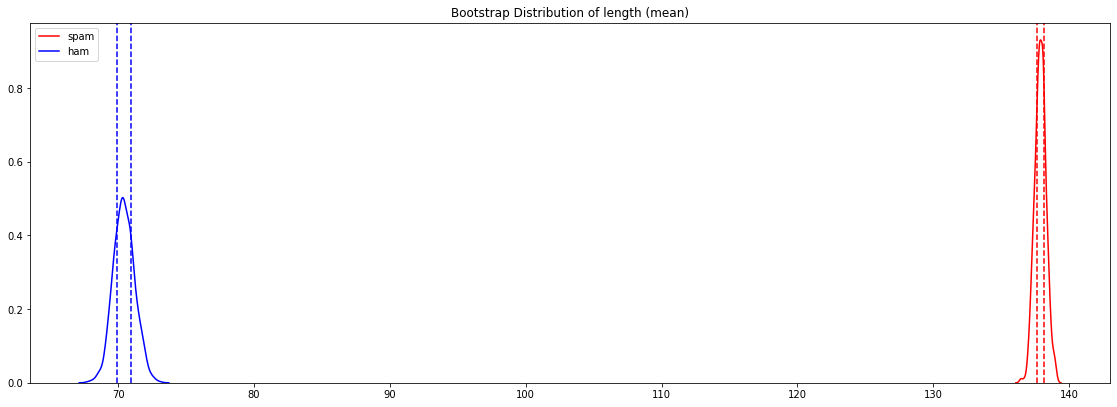

In [100]:
meanLength_spam = []
meanLength_ham = []

for i in range(1000):
    meanLength_spam.append(spam[spam['label'] == 'spam']['length'].sample(len(spam), replace = True).mean())
    meanLength_ham.append(spam[spam['label'] == 'ham']['length']. sample(len(spam), replace = True).mean())
    
lowerLength_spam = np.percentile(meanLength_spam, 25)
upperLength_spam = np.percentile(meanLength_spam, 75)
lowerLength_ham = np.percentile(meanLength_ham, 25)
upperLength_ham = np.percentile(meanLength_ham, 75)

fig = plt.figure(figsize = (15,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Bootstrap Distribution of length (mean)')
ax.axvline(lowerLength_spam, linestyle = '--', color = 'red')
ax.axvline(upperLength_spam, linestyle = '--', color = 'red')
ax.axvline(lowerLength_ham, linestyle = '--', color = 'blue')
ax.axvline(upperLength_ham, linestyle = '--', color = 'blue')

sns.distplot(meanLength_spam, ax = ax, hist = False, color = 'red', label = 'spam')
sns.distplot(meanLength_ham, ax = ax, hist = False, color = 'blue', label = 'ham')
plt.legend()

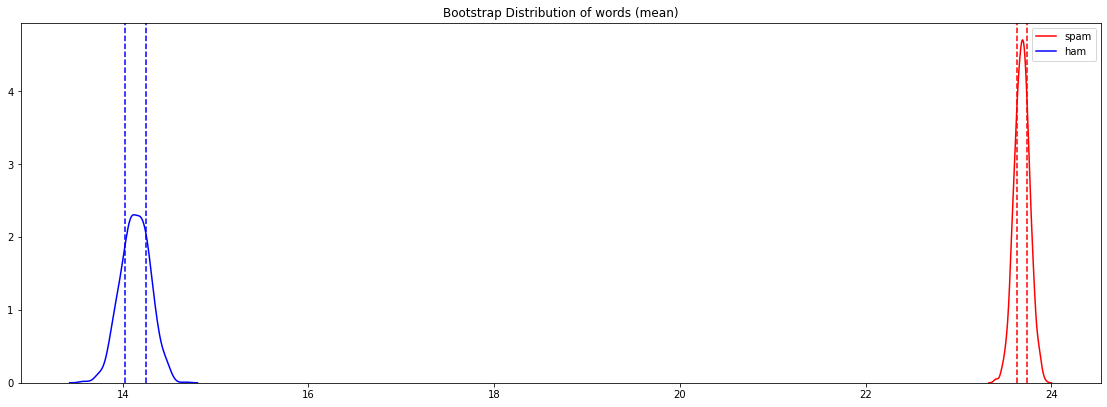

In [99]:
meanwords_spam = []
meanwords_ham = []

for i in range(1000):
    meanwords_spam.append(spam[spam['label'] == 'spam']['words'].sample(len(spam), replace = True).mean())
    meanwords_ham.append(spam[spam['label'] == 'ham']['words']. sample(len(spam), replace = True).mean())
    
lowerwords_spam = np.percentile(meanwords_spam, 25)
upperwords_spam = np.percentile(meanwords_spam, 75)
lowerwords_ham = np.percentile(meanwords_ham, 25)
upperwords_ham = np.percentile(meanwords_ham, 75)

fig = plt.figure(figsize = (15,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Bootstrap Distribution of words (mean)')
ax.axvline(lowerwords_spam, linestyle = '--', color = 'red')
ax.axvline(upperwords_spam, linestyle = '--', color = 'red')
ax.axvline(lowerwords_ham, linestyle = '--', color = 'blue')
ax.axvline(upperwords_ham, linestyle = '--', color = 'blue')

sns.distplot(meanwords_spam, ax = ax, hist = False, color = 'red', label = 'spam')
sns.distplot(meanwords_ham, ax = ax, hist = False, color = 'blue', label = 'ham')
plt.legend()

## WordCloud

In [66]:
hamWords = ''
spamWords = ''

for i in spam[spam['label'] == 'spam'].text:
    text = i.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spamWords += words + ' '
        
for i in spam[spam['label'] == 'ham'].text:
    text = i.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        hamWords += words + ' '

In [67]:
spamWordsCloud = WordCloud(max_font_size=100, max_words=100, width=500, height=300, background_color = 'white').generate(spamWords)
hamWordsCloud = WordCloud(max_font_size=100, max_words=100, width=500, height=300, background_color = 'white').generate(hamWords)

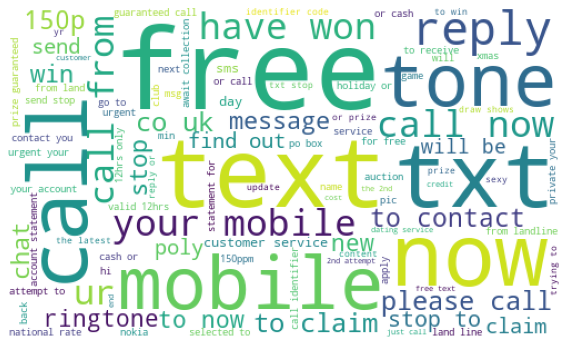

In [68]:
plt.figure(figsize=(8,8))
plt.imshow(spamWordsCloud)
plt.axis("off")
plt.tight_layout()
plt.show()

> Dapat dilihat bahwa kata-kata yang sering muncul pada pesan <i>spam</i> adalah <i>free, have won, text, please call, </i> dan <i> reply </i>. Kata-kata yang berbau ajakan atau seakan menang undian. 

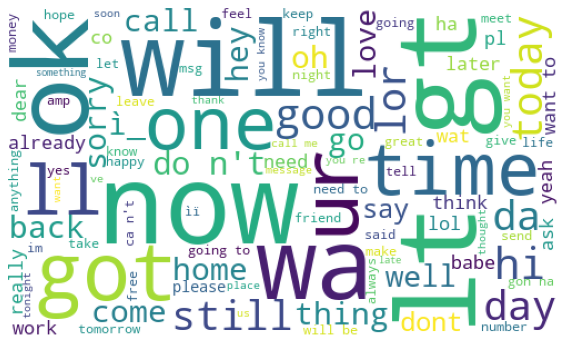

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(hamWordsCloud)
plt.axis("off")
plt.tight_layout()
plt.show()

> Sedangkan pada pesan <i> ham </i> adalah <i>ur, will, ok, gt, </i> dan <i> time </i>. Kata-katanya lebih gaul dan mengarah ke kata-kata singkatan.

# Preprocessing Text

In [120]:
stopWords = []
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stopWords.append(''.join(s))

In [121]:
def processing_text(x):
    
    nopunc = [char for char in x if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    clean_words = [x for x in nopunc.split() if x.lower() not in stopWords]
    
    return clean_words

# Modeling

In [144]:
spam['label'] = spam['label'].map({'spam' : 0, 'ham' : 1})

X = spam['text']
y = spam['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4135,) (1034,) (4135,) (1034,)


## MultinomialNB

In [182]:
NBParams = {
    'nb__alpha' : Real(low=0.3, high=1.3, prior='uniform'),
    'tfidf__use_idf' : [True, False]
}

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=processing_text)),  
    ('tfidf', TfidfTransformer()),  
    ('nb', MultinomialNB()),  
])

model = RandomizedSearchCV(pipeline, NBParams, cv = 3, random_state = 101)
model.fit(X_train, y_train)

print(model.best_params_)

{'nb__alpha': 0.37568189764121135, 'tfidf__use_idf': True}


In [183]:
y_pred = model.best_estimator_.predict(X_test)

In [184]:
confusion_matrix(y_test, y_pred)

array([[ 98,  16],
       [  1, 919]])

In [185]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       114
           1       0.98      1.00      0.99       920

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034



## XGBClassifier

In [186]:
XGBParams = {   
    'xgb__max_depth': Integer(low=3, high=10),
    'xgb__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'xgb__n_estimators': Integer(low=150, high=250),
    'xgb__subsample': Real(low=0.3, high=0.7, prior='uniform'),
    'xgb__gamma': Integer(low=1, high=9),
    'xgb__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'xgb__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
    'xgb__reg_lambda': Real(low=-3, high=1, prior='log-uniform'),
    'tfidf__use_idf' : [True, False]
}

In [187]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=processing_text)),  
    ('tfidf', TfidfTransformer()),  
    ('xgb', XGBClassifier(n_estimators = 200)),  
])

model = RandomizedSearchCV(pipeline, XGBParams, cv = 3, random_state = 101)
model.fit(X_train, y_train)

print(model.best_params_)

{'tfidf__use_idf': False, 'xgb__colsample_bytree': 0.9041206107168668, 'xgb__gamma': 3, 'xgb__learning_rate': 0.1000537631387682, 'xgb__max_depth': 7, 'xgb__n_estimators': 161, 'xgb__reg_alpha': 0.0016264233637290591, 'xgb__reg_lambda': 0.005165444387074998, 'xgb__subsample': 0.4769472526050979}


In [188]:
y_pred = model.best_estimator_.predict(X_test)

In [189]:
confusion_matrix(y_test, y_pred)

array([[ 85,  29],
       [  3, 917]])

In [190]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.75      0.84       114
           1       0.97      1.00      0.98       920

    accuracy                           0.97      1034
   macro avg       0.97      0.87      0.91      1034
weighted avg       0.97      0.97      0.97      1034



# Sanity Check

In [191]:
NBParams = {
    'nb__alpha' : Real(low=0.3, high=1.3, prior='uniform'),
    'tfidf__use_idf' : [True, False]
}

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=processing_text)),  
    ('tfidf', TfidfTransformer()),  
    ('nb', MultinomialNB()),  
])

model = RandomizedSearchCV(pipeline, NBParams, cv = 3, random_state = 101)
model.fit(X_train, y_train)

print(model.best_params_)

{'nb__alpha': 0.37568189764121135, 'tfidf__use_idf': True}


In [203]:
msg = ['Rofl. Its true to its name']
model.best_estimator_.predict(msg), model.best_estimator_.predict_proba(msg)

(array([1]), array([[0.05466743, 0.94533257]]))

In [218]:
msg = ['SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info']
model.best_estimator_.predict(msg), model.best_estimator_.predict_proba(msg)

(array([0]), array([[0.99648497, 0.00351503]]))

Saya akan mencoba salah satu spam berasal dari website ini https://www.adaptivemobile.com/newsroom/press-release/five-top-spam-texts-for-2012-revealed-in-adaptivemobiles-ongoing-threat-ana

In [219]:
msg = ['IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out.']
model.best_estimator_.predict(msg), model.best_estimator_.predict_proba(msg)

(array([0]), array([[0.87658548, 0.12341452]]))

> Model menebak dengan Baik.